# BCycle Austin trips

This notebook looks at the bike measurements that were recorded every 5 minutes during April and May 2016. The measurement time of 5 minutes was chosen to balance the amount of data to be recorded, and have a fine enough granularity to capture checkins (when a bike leaves a station) and checkouts (when a bike arrives at a station).

The limitation of the 5-minute sampling period is that if the same amount of bikes arrive and leave a station in a 5-minute period, we won't be able to discern this from the data.

All data was collected from the [BCycle Stations](https://austin.bcycle.com/stations/station-locations) webpage, which is publicly available. No efforts were made to track individuals in the system. The limitation of this approach is that we can't track individual trips, only where bikes were checked in and out.

The data dictionary for the bikes CSV file is below:

* `station_id`: A unique identifier for each of the station. Used to connect the `bikes.csv` time-varying table to the static `stations` table.
* `datetime`: The date and time of the bike measurement.
* `bikes`: How many bikes are available at the station, at this time.
* `docks`: How many docks are available at the station, at this time.


## Imports and data loading

Before getting started, let's import some useful libraries (including the bcycle_lib created for these notebooks), and load the stations CSV file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import seaborn as sns

from bcycle_lib.utils import *

%matplotlib inline
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [129]:
stations_df = load_stations()
bikes_df = load_bikes()
bikes_df.head()

,station_id,datetime,bikes,docks
0,1,2016-04-01,6,7
1,2,2016-04-01,5,8
2,3,2016-04-01,4,9
3,4,2016-04-01,7,11
4,5,2016-04-01,8,11


## Total bikes stored in BCycle stations 

We can aggregate the amount of bikes stored in stations by time, and plot this. To smooth out the spikes, we resample and take the mean every 3 hours to give a moving average.

Mean bikes in BCycle stations: 305, minimum: 234


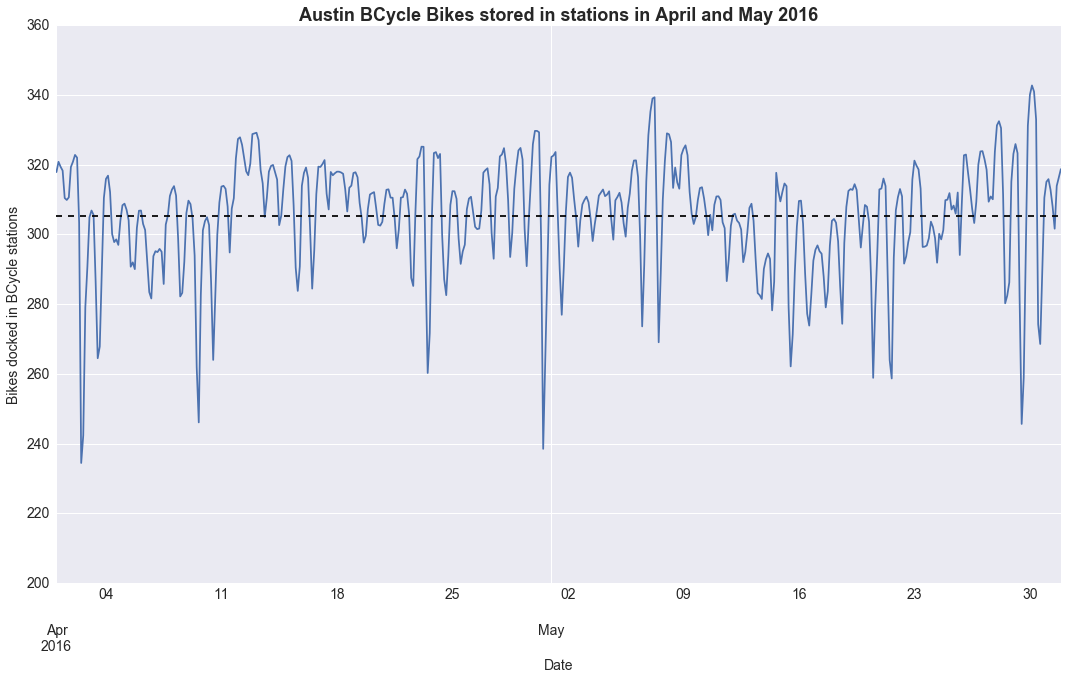

In [96]:
total_bikes_df = bikes_df.copy()
total_bikes_df = total_bikes_df.groupby('datetime').sum().reset_index()
total_bikes_df.index = total_bikes_df['datetime']
total_bikes_df = total_bikes_df.drop(['station_id', 'datetime', 'docks'], axis=1)

resampled_bikes_df = total_bikes_df.resample('3H').mean()
mean_bikes = resampled_bikes_df['bikes'].mean()
min_bikes = resampled_bikes_df['bikes'].min()

print('Mean bikes in BCycle stations: {:.0f}, minimum: {:.0f}'.format(mean_bikes, min_bikes))

fig, ax = plt.subplots(1,1, figsize=(18,10))
ax = resampled_bikes_df.plot(ax=ax, legend=None)
ax.axhline(y = mean_bikes, color = 'black', linestyle='dashed')
ax.set_ylim(ymin=200)
ax.set_xlabel('Date', fontdict={'size' : 14})
ax.set_ylabel('Bikes docked in BCycle stations', fontdict={'size' : 14})
ax.set_title('Austin BCycle Bikes stored in stations in April and May 2016', fontdict={'size' : 18, 'weight' : 'bold'})
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

This plot shows the amount of bikes stored in stations varies on a daily basis around the mean of 305. There are sharp dips over the weekends, where active bikes increase sharply. With a minimum number of bikes stored in stations of 234, this means the BCycle network never comes close to running out of bikes across the entire system. But individual stations do (see the bcycle_stations notebook for more information). 

## Active BCycle bikes during April and May 2016

To get an idea of how many concurrent BCycle trips are taking place, we need to calculate how many total bikes there are, and subtract the bikes currently stored in stations. As bikes may be added and removed from the system, I'll reset my estimate on the total amount of bikes based on the largest amount of bikes stored in stations for each day. I'm assuming this coincides with no bike trips taking place.

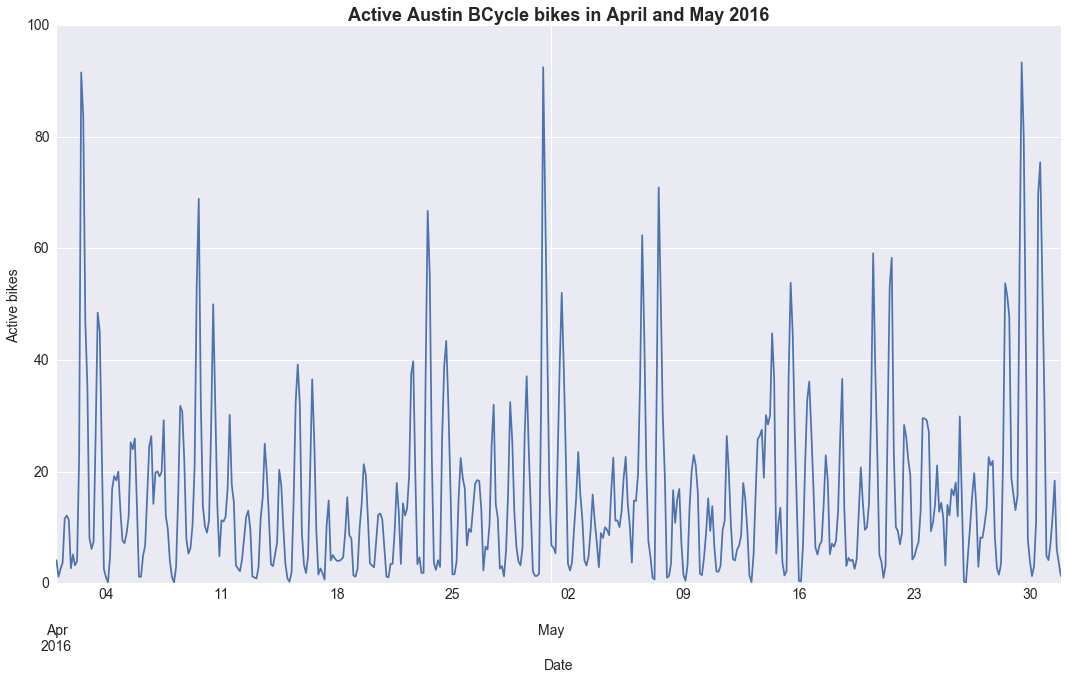

In [98]:
# First of all, work out the maximum bikes stored on each day
max_daily_bikes_df = total_bikes_df.copy().resample('1D').max()
max_daily_bikes_df = max_daily_bikes_df.reset_index()
max_daily_bikes_df.columns = [['date', 'max_bikes']]

# Merge in the maximum amount of bikes on each day using the date
active_bikes_df = total_bikes_df.copy().reset_index()
active_bikes_df['date'] = active_bikes_df['datetime'].dt.date
active_bikes_df['date'] = active_bikes_df['date'].astype('datetime64')
active_bikes_df = pd.merge(active_bikes_df, max_daily_bikes_df, on='date', how='left')

# Change the index back to datetime, calculate active bikes at each 5 minute period
active_bikes_df.index = active_bikes_df['datetime']
active_bikes_df['active_bikes'] = active_bikes_df['max_bikes'] - active_bikes_df['bikes']
active_bikes_df = active_bikes_df.drop(['date', 'datetime', 'bikes', 'max_bikes'], axis=1)

fig, ax = plt.subplots(1,1, figsize=(18,10))
ax = active_bikes_df.resample('3H').mean().plot(ax=ax, legend=None)
ax.set_xlabel('Date', fontdict={'size' : 14})
ax.set_ylabel('Active bikes', fontdict={'size' : 14})
ax.set_title('Active Austin BCycle bikes in April and May 2016', fontdict={'size' : 18, 'weight' : 'bold'})
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

This plot shows a similar pattern to the 'Bikes stored in stations' one, as you'd expect. There are noticeable dips every day, as there are few active bikes overnight (midnight-to-6AM). During the day, active bikes peak, with larger peaks on the weekend. The first weekend of every month seems to have a larger peak than other weekends (maybe people are paid monthly and go out to celebrate getting their paycheck?). The effect of the Memorial Day national holiday can also be seen on May 30th.

## Active bikes by day of the week

To see how the amount of active bikes varies by day of the week, we can get a feel for how much variation there is in the active bikes. This is a bit involved - we first need to take the average amount of bike in each 3-hour window (midnight-to-3AM, 3AM-to-6AM, etc). This is known as a moving average, and smooths out any sharp peaks or dips in the data.

Once we have the windowed average, we can use these figures to create a distribution for each day of the week, and plot this using a boxplot below.

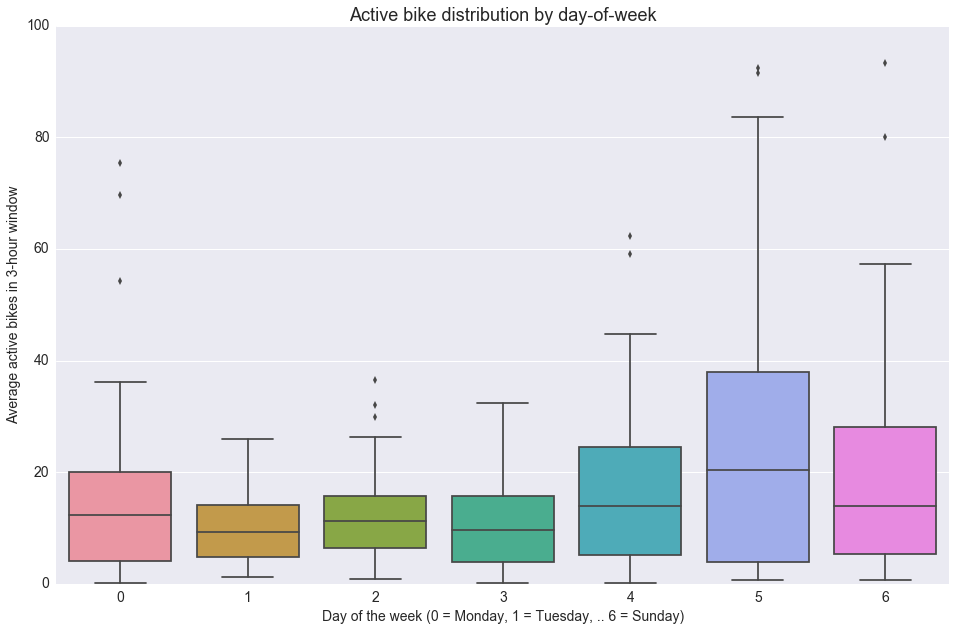

In [229]:
daily_bikes_df = active_bikes_df.copy()
daily_bikes_df = daily_bikes_df.resample('3H').mean()
daily_bikes_df = daily_bikes_df.reset_index()
daily_bikes_df['dayofweek'] = daily_bikes_df['datetime'].dt.dayofweek

fig, ax = plt.subplots(1,1, figsize=(16,10))
ax = sns.boxplot(data=daily_bikes_df, x="dayofweek", y="active_bikes")
ax.set_xlabel('Day of the week (0 = Monday, 1 = Tuesday, .. 6 = Sunday)', fontdict={'size' : 14})
ax.set_ylabel('Average active bikes in 3-hour window', fontdict={'size' : 14})
ax.set_title('Active bike distribution by day-of-week', fontdict={'size' : 18})
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

The plot above shows similar distributions for the middle weekdays (Tuesday, Wednesday, and Thursday), this is likely because the same people are using the bikes for commuting purposes. On the weekend, there are more active bikes in the system, especially on Saturday. This shows there are a lot of people who use BCycle only on the weekends (going out at night, cycling around downtown, or on the Ladybird Lake trail.

## Tidy data and Time Series

Hadley Wickham has a great paper on [tidy data](http://vita.had.co.nz/papers/tidy-data.pdf) which gives guidelines on how to format data so it can be easily aggregated. The CSV file is already stored in a tidy data format (one measurement per line of docks and bikes), but to calculate checkins and checkouts I need to sort first by `station_id`, and then by `datetime`.

Once I have the sorting order corect, I can segment the dataframe by `station_id` and calculate the diffs between each sample (spaced at 5 minutes). In the event of a checkin, the amount of bikes increments, and the amount of docks decrements. For a checkout the reverse is true (bikes decrements, docks increments).

In [167]:
# Sort the bikes_df dataframe by station_id first, and then datetime so we
# can use a diff() and get the changes by time for each station
bikes_df = load_bikes()
bikes_df = bikes_df.sort_values(['station_id', 'datetime']).copy()
stations = bikes_df['station_id'].unique()

# Our dataframe is grouped by station_id first now, so grab each station in
# turn and do a diff() on bikes and docks for each station individually
diff_list = list()
for station in stations:
    station_diff_df = bikes_df[bikes_df['station_id'] == station].copy()
    station_diff_df['bikes_diff'] = station_diff_df['bikes'].diff()
    station_diff_df['docks_diff'] = station_diff_df['docks'].diff()
    diff_list.append(station_diff_df)

# Concatenate the station dataframes back together into a single one.
# Make sure we didn't lose any rows in the process (!)
bikes_diff_df = pd.concat(diff_list)

# The first row of each station-wise diff is filled with NaNs, store a 0 in these fields
# then we can convert the data type from floats to int8s 
bikes_diff_df.fillna(0, inplace=True)
bikes_diff_df[['bikes_diff', 'docks_diff']] = bikes_diff_df[['bikes_diff', 'docks_diff']].astype(np.int8)
bikes_diff_df.index = bikes_diff_df['datetime']
bikes_diff_df.drop('datetime', axis=1, inplace=True)
assert(bikes_df.shape[0] == bikes_diff_df.shape[0]) 
bikes_diff_df.describe()

,station_id,bikes,docks,bikes_diff,docks_diff
count,843126.000000,843126.000000,843126.000000,843126.000000,843126.000000
mean,24.602239,6.337278,6.311496,0.000004,-0.000009
std,13.912868,3.299118,3.356976,0.411478,0.411260
min,1.000000,0.000000,0.000000,-9.000000,-11.000000
25%,13.000000,4.000000,4.000000,0.000000,0.000000
50%,25.000000,6.000000,6.000000,0.000000,0.000000
75%,37.000000,8.000000,9.000000,0.000000,0.000000
max,50.000000,19.000000,19.000000,11.000000,9.000000


This table shows the distribution is heavily weighted towards 0 checkouts. The 1Q, median, and 3Q values are all 0 ! This makes sense intuitively, as there will be large amounts of 5-minute periods where individual stations don't have any checkouts or checkins, for example overnight. 

## Converting differences in bikes to checkouts and checkins

Now we have the differences in bikes every 5 minutes, we can calculate how many checkins and checkouts there were in 5 minutes. If the amount of bikes **decreases** (the difference is negative) then these represent **checkouts**. If the amount of bikes **increases** (the difference is positive) these are **checkins**.

We might want to treat checkouts and checkins independently in the analysis later on, so I 'll keep them separate for now. We can't just resample and sum the bike differences, otherwise the checkouts and checkins will balance themselves out, and we'll lose the true information.

In [178]:
bike_trips_df = bikes_diff_df.copy()

# Checkouts are all negative `bikes_diff` values. Filter these and take abs()
bike_trips_df['checkouts'] = bike_trips_df['bikes_diff']
bike_trips_df.loc[bike_trips_df['checkouts'] > 0, 'checkouts'] = 0
bike_trips_df['checkouts'] = bike_trips_df['checkouts'].abs()

# Conversely, checkins are positive `bikes_diff` values
bike_trips_df['checkins'] = bike_trips_df['bikes_diff']
bike_trips_df.loc[bike_trips_df['checkins'] < 0, 'checkins'] = 0
bike_trips_df['checkins'] = bike_trips_df['checkins'].abs()

# Might want to use sum of checkouts and checkins for find "busiest" stations
bike_trips_df['totals'] = bike_trips_df['checkouts'] + bike_trips_df['checkins']
bike_trips_df.head()

,station_id,bikes,docks,bikes_diff,docks_diff,checkouts,checkins,totals
datetime,,,,,,,,
2016-04-01 00:00:00,1,6,7,0,0,0,0,0
2016-04-01 00:05:00,1,6,7,0,0,0,0,0
2016-04-01 00:10:00,1,6,7,0,0,0,0,0
2016-04-01 00:15:00,1,6,7,0,0,0,0,0
2016-04-01 00:20:00,1,6,7,0,0,0,0,0


## Checkouts based on the day of the week, and time

Now we have the amount of checkouts from each station every 5 minutes in April/May, we can look into the checkout patterns in more detail. To get a feel for how the checkouts vary by time, we can add up checkouts over all the stations and see how they vary depending on the time and day-of-the week. As we're plotting the data by hour, we can sum up all the checkouts per hour.

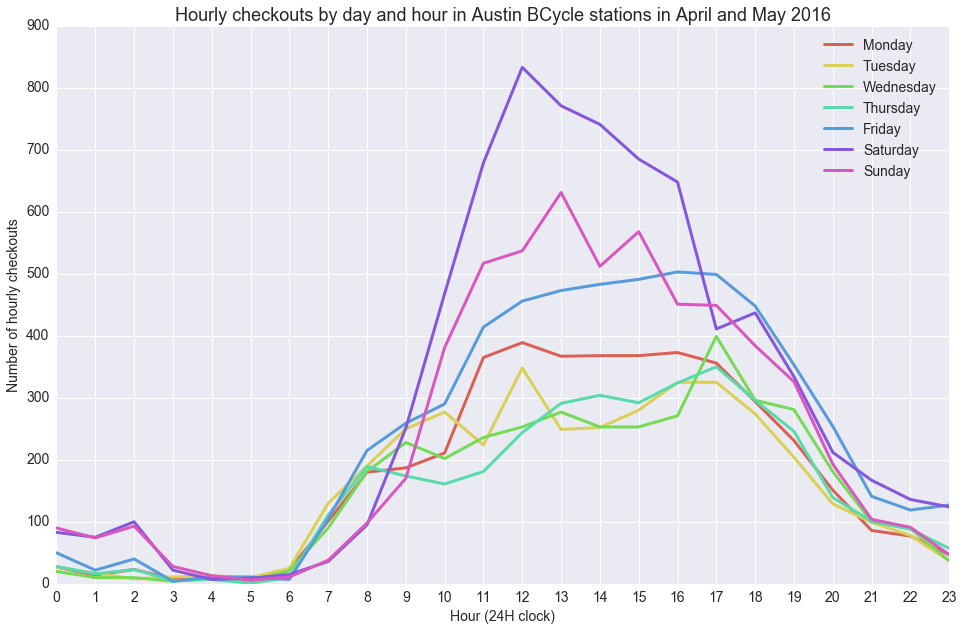

In [227]:
checkouts_df = bike_trips_df.copy()
checkouts_df = checkouts_df.reset_index()
checkouts_df['dayofweek'] = checkouts_df['datetime'].dt.weekday_name
checkouts_df['hour'] = checkouts_df['datetime'].dt.hour
checkouts_df = checkouts_df.groupby(['dayofweek', 'hour']).sum().reset_index()
checkouts_df = checkouts_df[['dayofweek', 'hour', 'checkouts']]
checkouts_df = checkouts_df.pivot_table(values='checkouts', index='hour', columns='dayofweek')

checkouts_df = checkouts_df[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
day_palette = sns.color_palette("hls", 7) # Need to have 7 distinct colours

fig, ax = plt.subplots(1,1, figsize=(16,10))
ax = checkouts_df.plot.line(ax=ax, linewidth=3, color=day_palette)
ax.set_xlabel('Hour (24H clock)', fontdict={'size' : 14})
ax.set_ylabel('Number of hourly checkouts', fontdict={'size' : 14})
ax.set_title('Hourly checkouts by day and hour in Austin BCycle stations in April and May 2016'
             ,fontdict={'size' : 18})
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.xaxis.set_ticks(checkouts_df.index)
ax.legend(fontsize=14)


This plot shows a lot of useful information on the checkouts-per-hour. Let's unpack it:

* The amount of checkouts during the day (9AM to midnight) is roughly the same for Tuesday, Wednesday, and Thursday (around 300 checkouts per hour during the day). Friday follows these days up until around 10AM, when the number of checkouts rises steadily to hit 500 per hour at 5PM. This could be caused by people cycling to Happy Hours after work on a Friday, or going out after work. The weekend days (Saturday and Sunday) have higher peaks of bike checkouts during the day (~610 on Sunday, and ~825 on Saturday).


* The time between 6AM and 9AM shows the difference between commuting trips on the weekdays, and recreational use on the weekends. The weekday checkouts start increasing at 6AM, hitting 200 checkouts per hour at 8AM as people head into work for the day. The good people of Austin take a well-earned lie in on the weekend, taking until 9AM to hit 200 checkouts per hour, with a shallower increase. On Saturday and Sunday there are also ~100 checkouts per hour up until 2AM-3AM, so they probably need a lie-in after having a few beers the night before.

## Checkouts by station on weekdays and weekends

Now we have an idea of how the checkouts vary by time, we can look at how they vary by station. A heatmap shows how many checkouts there are for each of the 50 stations for each hour-of-the day. As there seem to be different patterns for weekdays and weekends, let's plot these separately and compare.

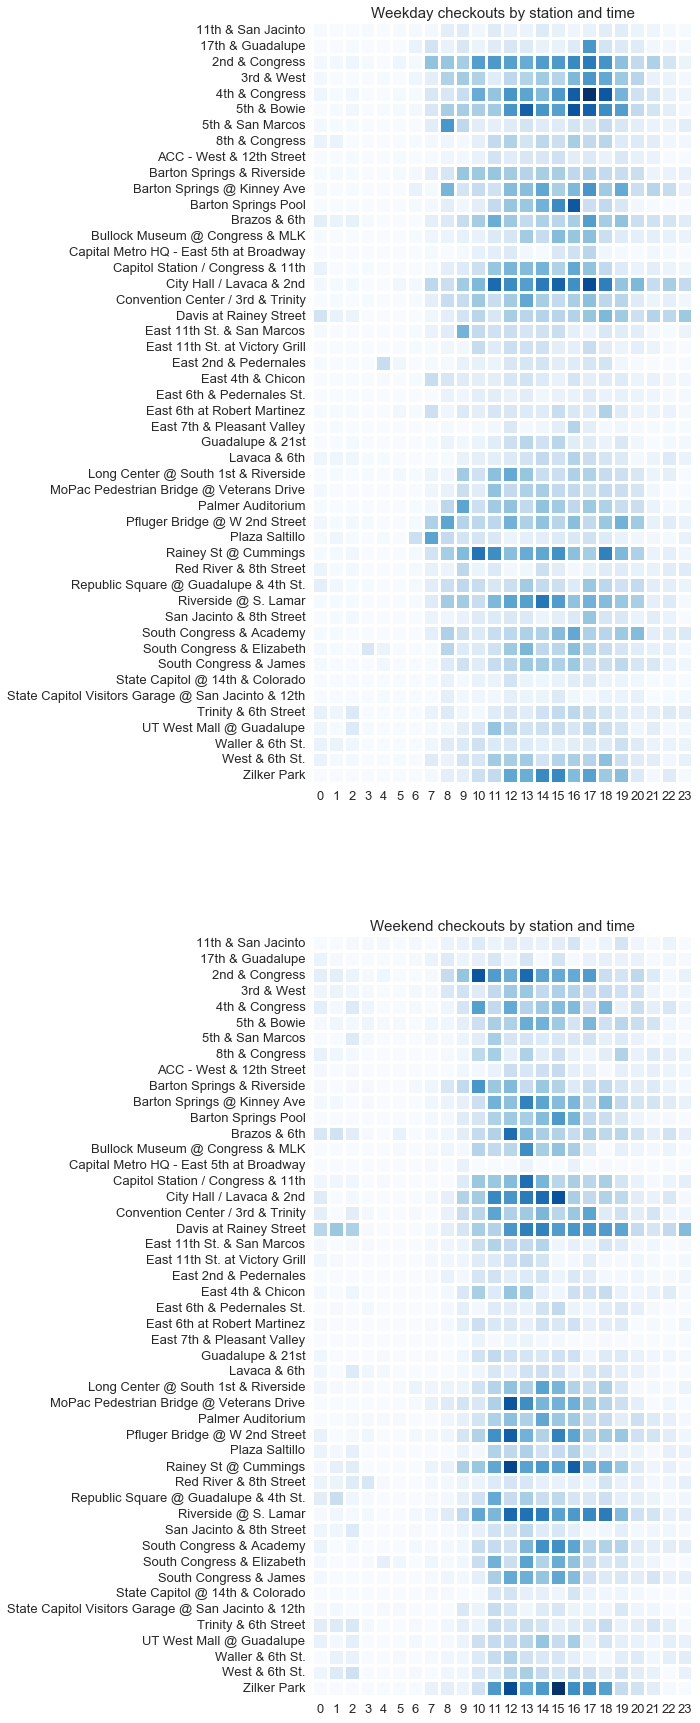

In [356]:
heatmap_df = bike_trips_df.copy()

heatmap_df = heatmap_df.reset_index()
heatmap_df['dayofweek'] = heatmap_df['datetime'].dt.dayofweek
heatmap_df['hour'] = heatmap_df['datetime'].dt.hour
heatmap_df['weekday'] = heatmap_df['datetime'].dt.dayofweek < 5
heatmap_df = heatmap_df.groupby(['weekday', 'station_id', 'hour']).sum().reset_index()
heatmap_df = heatmap_df[['weekday', 'station_id', 'hour', 'checkouts']]
heatmap_df = heatmap_df[heatmap_df['station_id'] < 49]

heatmap_df = pd.merge(heatmap_df, stations_df[['station_id', 'name']])

weekday_df = heatmap_df[heatmap_df['weekday']].pivot_table(values='checkouts', index='name', columns='hour')
weekend_df = heatmap_df[~heatmap_df['weekday']].pivot_table(values='checkouts', index='name', columns='hour')

weekday_df = weekday_df / 5.0 # Normalize checkouts by amount of days
weekend_df = weekend_df / 2.0

weekday_max = weekday_df.max().max() # Take max over stations and hours
weekend_max = weekend_df.max().max() # Take max over stations and hours

fig, ax = plt.subplots(2, 1, figsize=(10,30))
sns.heatmap(data=weekday_df, robust=True, ax=ax[0], linewidth=2, square=True, vmin=0, vmax=weekday_max, cbar=False, cmap='Blues')
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].set_title('Weekday checkouts by station and time', fontdict={'size' : 15})
ax[0].tick_params(axis='x', labelsize=13)
ax[0].tick_params(axis='y', labelsize=13)

sns.heatmap(data=weekend_df, robust=True, ax=ax[1], linewidth=2, square=True, vmin=0, vmax=weekend_max, cbar=False, cmap='Blues')
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].set_title('Weekend checkouts by station and time', fontdict={'size' : 15})
ax[1].tick_params(axis='x', labelsize=13)
ax[1].tick_params(axis='y', labelsize=13)


In [323]:
weekend_df

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
name,,,,,,,,,,,,,,,,,,,,,
11th & San Jacinto,0.0,0.0,0.5,0.5,1.0,0.0,1.0,0.0,2.5,3.0,...,3.0,4.5,7.0,1.0,2.5,7.0,2.0,0.5,2.5,0.0
17th & Guadalupe,2.5,0.5,0.0,0.0,0.0,0.0,0.5,2.5,5.0,2.5,...,0.5,7.5,0.5,3.0,3.5,3.0,3.0,0.5,1.5,0.5
2nd & Congress,4.0,4.0,2.5,0.5,1.5,0.0,0.0,0.5,10.0,16.5,...,22.5,21.5,21.5,24.0,9.5,7.5,11.5,5.5,1.0,3.0
3rd & West,2.0,2.5,1.5,0.5,0.0,0.0,1.0,0.5,6.0,8.0,...,11.0,13.5,12.5,10.5,10.5,8.5,8.0,2.0,0.5,1.0
4th & Congress,4.0,1.0,5.5,2.0,0.0,0.0,0.5,0.0,2.0,7.0,...,15.5,18.0,18.5,9.0,18.5,3.0,9.5,4.0,6.5,2.0
5th & Bowie,0.5,1.5,1.0,2.0,0.5,0.5,0.0,1.5,1.5,4.0,...,20.0,15.5,7.5,19.0,8.5,12.0,9.5,7.5,1.5,0.5
5th & San Marcos,0.0,0.0,5.5,1.0,0.0,0.0,0.0,1.0,0.5,2.5,...,5.5,6.0,6.0,8.0,3.5,5.5,3.0,0.5,1.5,0.0
8th & Congress,3.0,1.5,1.0,0.0,0.0,0.0,0.0,0.0,0.5,1.5,...,4.5,9.0,3.0,2.0,4.5,13.0,3.0,5.5,3.5,2.5
ACC - West & 12th Street,1.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,1.5,...,9.0,10.5,4.0,3.5,0.5,3.5,3.0,3.5,2.5,1.5


# Cleanup section below !! These parts might not make it into the post

## Checkouts distribution

Now we have the raw differences, let's check to see if `change in bikes` is always `-1 * the change in docks`. This is equivalent to saying the capacity of each of the stations is fixed. 

**TODO ! This is an optional section, to try and work out why the capacities of docks change**

In [55]:
checkouts_df = bikes_diff_df.copy()
checkouts_df['bikes_docks_diff'] = checkouts_df['bikes_diff'] + checkouts_df['docks_diff']
zero_mask = checkouts_df['bikes_docks_diff'] != 0
checkouts_df = checkouts_df[zero_mask]

checkouts_df = checkouts_df.reset_index()
checkouts_df = checkouts_df.sort_values('datetime')
checkouts_df

# station_mask = checkouts_df['station_id'] == 43

# temp_df = bikes_diff_df['2016-04-03 13:14:00':'2016-04-03 14:20:05']
# temp_df = temp_df[temp_df['station_id'] == 43]
# temp_df

# bikes_diff_df.groupby('station_id').head()
# bikes_diff_df['bikes_docks_diff'].plot.hist()
# bikes_diff_df['bikes_docks_diff'].plot.line(size=10)


,datetime,station_id,bikes,docks,bikes_diff,docks_diff,bikes_docks_diff
189,2016-04-02 16:25:00,39,11,4,-1,0,-1
211,2016-04-03 13:20:00,43,5,3,-1,0,-1
212,2016-04-03 14:15:00,43,4,5,4,-3,1
190,2016-04-04 09:00:00,39,8,8,5,-4,1
61,2016-04-04 14:20:00,16,4,7,-1,0,-1
191,2016-04-04 14:20:00,39,9,6,-1,0,-1
114,2016-04-05 10:00:00,25,4,8,-1,0,-1
115,2016-04-05 10:30:00,25,5,8,1,0,1
183,2016-04-05 14:30:00,38,8,4,-1,0,-1
184,2016-04-05 15:05:00,38,8,5,1,0,1


Interesting ! There are ~240 cases where bike counters incremented or decremented, and the amount of docks free didn't do the opposite. When this happens, there seem to be pairs of events.


* Bike checked in for repair: bike stays same, docks decrements
* Broken bike repaired in situ: bike increments, docks stays the same
* Broken bike taken away for repair: 
* Broken bike brought back 


* Bike decrements, dock decrements
* Bike decrements, dock increments



* Bike count increments, dock count stays the same: When a bike is marked as needing repair,

*  Bike count decrements, Dock count stays the same: This could happen when a bike needs repairing. In this case, the broken bike isn't available for checkout (so 

* Bike count stays the same, dock count increments: Once a bike is checked in and flagged as needing a repair, the BCycle truck has to bring it to the garage to be fixed. When it picks the bike up, the bike count stays the same (remember the broken bike doesn't count towards the bikes number), but the number of docks increases by 1.



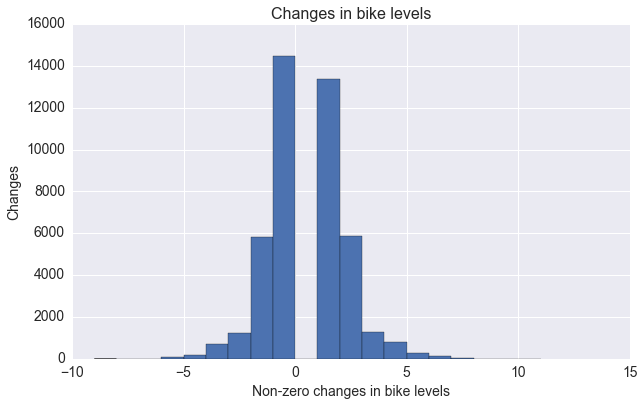

In [8]:
ax = bikes_diff_df[bikes_diff_df['bikes_diff'] != 0]['bikes_diff'].plot.hist(bins=20, figsize=(10,6))
ax.set_xlabel('Non-zero changes in bike levels', fontdict={'size':14})
ax.set_ylabel('Changes', fontdict={'size':14})
ax.set_title('Changes in bike levels', fontdict={'size':16})

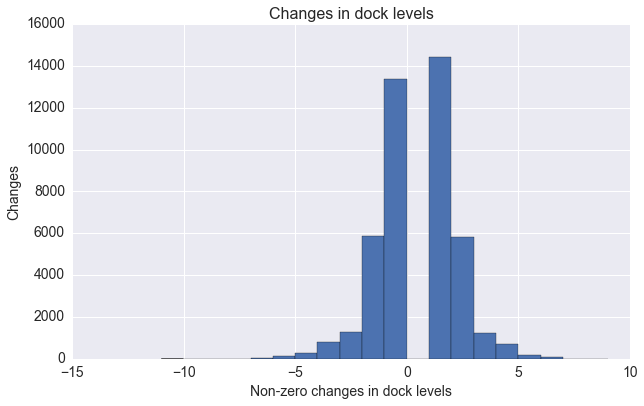

In [9]:
ax = bikes_diff_df[bikes_diff_df['docks_diff'] != 0]['docks_diff'].plot.hist(bins=20, figsize=(10,6))
ax.set_xlabel('Non-zero changes in dock levels', fontdict={'size':14})
ax.set_ylabel('Changes', fontdict={'size':14})
ax.set_title('Changes in dock levels', fontdict={'size':16})

## Aggregating checkins and checkouts by day-of-the week

Now we've examined the checkins and checkouts on a 5-minute basis, we can aggregate the checkins and checkouts by the day of the week and hour. To do this, we need to drop all the negative differences from the `bikes_diff` and `docks_diff` columns. After that, we can aggregate by summing the differences in each hour.

In [10]:
bikes_agg_df = bikes_diff_df.copy()

bikes_agg_df = bikes_agg_df.reset_index()
bikes_agg_df['bikes_diff'] = bikes_agg_df['bikes_diff'].fillna(0)
bikes_agg_df['docks_diff'] = bikes_agg_df['docks_diff'].fillna(0)
bikes_agg_df.loc[bikes_agg_df['bikes_diff'] < 0, 'bikes_diff'] = 0
bikes_agg_df.loc[bikes_agg_df['docks_diff'] < 0, 'docks_diff'] = 0

bikes_agg_df['dayofweek'] = bikes_agg_df['datetime'].dt.dayofweek
bikes_agg_df['weekend'] = bikes_agg_df['datetime'].dt.dayofweek >= 5
bikes_agg_df['hour'] = bikes_agg_df['datetime'].dt.hour

bikes_agg_df = bikes_agg_df.groupby(['station_id']).sum()
# bikes_agg_df = bikes_agg_df[['dayofweek', 'bikes_diff', 'docks_diff']]
# bikes_agg_df.columns = ['dayofweek', 'checkins', 'checkouts']

# bikes_agg_df.describe()
bikes_agg_df.head(30)
# bikes_agg_df.iloc[100000:100200]

# ax = sns.boxplot(x='dayofweek', y='checkouts', data=bikes_agg_df)
# ax.set_xlabel('Day of week (0 = Monday, 1 = Tuesday, .. 6 = Sunday)', fontdict={'size':14})
# ax.set_ylabel('Checkouts count', fontdict={'size':14})
# ax.set_title('Checkouts by day of week', fontdict={'size':16})


,bikes,docks,bikes_diff,docks_diff,dayofweek,weekend,hour
station_id,,,,,,,
1,134786.0,92484.0,1536.0,1531.0,52735,5157.0,201829
2,104356.0,123088.0,1289.0,1291.0,52735,5157.0,201829
3,107199.0,120002.0,556.0,559.0,52735,5157.0,201829
4,121510.0,193418.0,874.0,875.0,52735,5157.0,201829
5,193535.0,138622.0,1588.0,1585.0,52735,5157.0,201829
6,97251.0,130204.0,1278.0,1281.0,52735,5157.0,201829
7,119277.0,72675.0,867.0,864.0,52735,5157.0,201829
8,85445.0,71988.0,761.0,761.0,52735,5157.0,201829
9,107841.0,119260.0,765.0,777.0,52735,5157.0,201829


In [11]:
bikes_agg_df = bikes_diff_df.copy()

bikes_agg_df['bikes_diff'] = bikes_agg_df['bikes_diff'].fillna(0)
bikes_agg_df['docks_diff'] = bikes_agg_df['docks_diff'].fillna(0)
bikes_agg_df.loc[bikes_agg_df['bikes_diff'] < 0, 'bikes_diff'] = 0
bikes_agg_df.loc[bikes_agg_df['docks_diff'] < 0, 'docks_diff'] = 0

bikes_agg_df['dayofweek'] = bikes_agg_df['datetime'].dt.dayofweek
bikes_agg_df['weekend'] = bikes_agg_df['datetime'].dt.dayofweek >= 5
bikes_agg_df['hour'] = bikes_agg_df['datetime'].dt.hour

bikes_agg_df = bikes_agg_df.groupby(['dayofweek', 'hour']).sum().reset_index()
bikes_agg_df = bikes_agg_df[['dayofweek', 'hour', 'bikes_diff', 'docks_diff']]
bikes_agg_df.columns = ['dayofweek', 'hour', 'checkins', 'checkouts']

# Plot out the hourly counts by date in a grid
g = sns.factorplot(x="hour", col="dayofweek", col_wrap=3,
                    data=bikes_agg_df,
                    y='checkins', size=3, aspect=1.8)
g.fig.subplots_adjust(wspace=0.2, hspace=0.2)

KeyError: 'datetime'

The plots above show the amount of checkouts aggregated across all the stations on each day of the week, by hour. Monday to Friday show very similar patterns of usage: there's a peak around 7-8AM, usage flattens at around 200 - 400 checkouts per hour during the day, and then tails off to around 0 at midnight. On Friday checkouts are between 400 and 600 between midday and 7PM instead of 200 - 400.

The weekend trends are different. Between midnight and 3AM there are around 100 checkouts per hour, much more than during the week. This is probably due to people spending the night out, and taking a BCycle to get home afterwards. On the weekends, usage shows a much higher peak of 800 checkouts per hour on Saturday and 600 checkouts per hour on Sunday. The initial ramp up on weekends us also later than during the week, occuring at 8AM-9AM instead of 6AM-7AM during the week.

## How many bike trips were there on each day?

Now we've separated out the checkins and checkouts, we can plot out how many checkouts there were on each day during April and May 2016. This tells us how many bike trips were made. We can use pandas' timeseries resampling, which makes this really easy. To keep some granularity of trips during each day, resample to less than a day.

In [ ]:
bikes_daily_df = bikes_diff_df.copy()

bikes_daily_df['bikes_diff'] = bikes_daily_df['bikes_diff'].fillna(0)
bikes_daily_df['docks_diff'] = bikes_daily_df['docks_diff'].fillna(0)
bikes_daily_df.loc[bikes_daily_df['bikes_diff'] < 0, 'bikes_diff'] = 0
bikes_daily_df.loc[bikes_daily_df['docks_diff'] < 0, 'docks_diff'] = 0

# bikes_daily_df['dayofyear'] = bikes_daily_df['datetime'].dt.dayofyear
# bikes_daily_df = bikes_daily_df.groupby('dayofyear').sum().reset_index()

bikes_daily_df.index = bikes_daily_df['datetime']
bikes_daily_df = bikes_daily_df.drop(['datetime', 'bikes', 'docks', 'docks_diff'], axis=1)
bikes_daily_df.columns = [['station_id', 'checkouts']]
bikes_daily_df = bikes_daily_df.resample('3H').sum()
bikes_daily_df.head()

ax = bikes_daily_df['checkouts'].plot(figsize=(16,8))
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Number of trips', fontsize=14)
ax.set_title('Trips by date in April/May 2016', fontdict={'size' : 16, 'weight' : 'bold'})

The plot above shows the amount of trips resampled to 3 hours, smoothing the trip values so the daily variation is visible. As well as the daily variation, there is also a weekly trend where the Friday, Saturday, and Sunday all have larger peaks. There are also some missing peaks, for example around the 18th April, perhaps bad weather was the cause for this drop in trips?

## Comparing stations


In [ ]:
bikes_agg_df.head()

In [ ]:
bikes_ts_df = bikes_diff_df.copy()

bikes_ts_df['bikes_diff'] = bikes_ts_df['bikes_diff'].fillna(0)
bikes_ts_df['docks_diff'] = bikes_ts_df['docks_diff'].fillna(0)
bikes_ts_df.loc[bikes_ts_df['bikes_diff'] < 0, 'bikes_diff'] = 0
bikes_ts_df.loc[bikes_ts_df['docks_diff'] < 0, 'docks_diff'] = 0


bikes_ts_df = bikes_ts_df.pivot_table(values='bikes_diff', index='datetime', columns='station_id')

# ax = bikes_ts_df.resample('3H').sum().plot(figsize=(16,8), legend=False)
# ax.set_xlabel('Date', fontsize=14)
# ax.set_ylabel('Number of trips', fontsize=14)
# ax.set_title('Trips by date in April/May 2016', fontdict={'size' : 16, 'weight' : 'bold'})

# Correlation matrix is symmetric with diagonals set to 0
corr_df = bikes_ts_df.corr()
corr_matrix = corr_df.values
corr_matrix -= np.eye(corr_matrix.shape[0]) # Zero the diagonals
corr_matrix = corr_matrix[:48,:48] # Station
# print(corr_matrix)
fig, ax = plt.subplots(1,1, figsize=(16,16))
ax = sns.heatmap(corr_matrix)
ax.set_xlabel('Station ID', fontsize=14)
ax.set_ylabel('Station ID', fontsize=14)
ax.set_xticklabels(range(1,49)) # Need to convert from numpy 0-based index
ax.set_yticklabels(range(48,0, -1)) # to 1-based station_id index
ax.set_title('Station trip time series correlation in April/May 2016', fontdict={'size' : 16, 'weight' : 'bold'})

In [ ]:
# Now we have the correlations, let's look at the top 3 correlated pairs of stations, and bottom 3
# TODO ! How to interpret this ?!
# corr_matrix.argsort()


# Pick a station. What are the top 3 correlated stations with it?
# sorted_idx = corr_matrix.argsort(axis=0)
# print(sorted_idx)

# for idx in range()

# corr_stations = dict()

# for corr_row in corr_df.iterrows():
#     row = corr_row[1]
#     sorted_idx = row.argsort()
#     print(sorted_idx)
    
    
#### Warning - everything is zero-indexed as it uses numpy
#### but in the dataframe station ids start at 1

# Create a dictionary with key station_id, value is list of correlated stations
row_idx = corr_matrix.argsort(axis=0)
print(row_idx[0])
print(corr_matrix[:,0])

print('Max {}, min {}'.format(corr_matrix[row_idx[0],0], corr_matrix[row_idx[-1],0]))
